In [1]:
from stock.tw_stock import tw_stock
from stock.update_data import update_data
from stock.plot import plot
from stock.strategy import 選股模式一,雙重金死叉策略,dmi策略,bbi策略,漲幅大於,外陸資連三買超股數,投信連三買超股數
import datetime ,sqlite3
import pandas as pd
import time
import requests
from io import StringIO
import numpy as np
tw_stock=tw_stock()
update_data=update_data()
plot=plot()
#update_data.更新_每日股價()

每日股價最新日期(上市): 2022-03-30 00:00:00
每日股價最新日期(上櫃): 2022-03-30 00:00:00
每日股價最新日期(三大法人): 2022-03-30 00:00:00


In [2]:
#prepare data............................................................................................
time_start = time.time() #開始計時
date_today=datetime.datetime(2022,4,1)
date_1years_ago=date_today-datetime.timedelta(days=500)
#-------------------------------------------------------------------------------------------------------
close=tw_stock.get("close",date_1years_ago,date_today)
high=tw_stock.get("high",date_1years_ago,date_today)
open_=tw_stock.get("open",date_1years_ago,date_today)
low=tw_stock.get("open",date_1years_ago,date_today)
volume=tw_stock.get("volume",date_1years_ago,date_today)
SMA_20=tw_stock.get_均線('SMA',close,20)
SMA_5_volume=tw_stock.get_均線('SMA',volume,5)
三大法人買賣超=tw_stock.get("三大法人買賣超股數",date_today)
投信買賣超=tw_stock.get("投信買賣超股數",date_today)
外陸資買賣超=tw_stock.get("外陸資買賣超股數_不含外資自營商",date_today)
#-------------------------------------------------------------------------------------------------------
dfk,dfd=tw_stock.get_technical_index("KD",close,open_,high,low,volume)
macd,macdsignal,macdhist=tw_stock.get_technical_index("MACD",close,open_,high,low,volume)
#-------------------------------------------------------------------------------------------------------
OBV=tw_stock.get_technical_index("OBV",close,open_,high,low,volume)
obv_ema=tw_stock.get_均線("SMA",OBV,均線_天數=144)
EMA_144=tw_stock.get_均線("EMA",close,均線_天數=144)
MINUS_DI=tw_stock.get_technical_index("MINUS_DI",close,open_,high,low,volume)
PLUS_DI=tw_stock.get_technical_index("PLUS_DI",close,open_,high,low,volume)
ADX=tw_stock.get_technical_index("ADX",close,open_,high,low,volume)
#-------------------------------------------------------------------------------------------------------
EMA_8=tw_stock.get_均線("EMA",close,均線_天數=8)
EMA_13=tw_stock.get_均線("EMA",close,均線_天數=13)
EMA_21=tw_stock.get_均線("EMA",close,均線_天數=21)
EMA_34=tw_stock.get_均線("EMA",close,均線_天數=34)
EMA_55=tw_stock.get_均線("EMA",close,均線_天數=55)
EMA_89=tw_stock.get_均線("EMA",close,均線_天數=89)
EMA_144=tw_stock.get_均線("EMA",close,均線_天數=144)
EMA_233=tw_stock.get_均線("EMA",close,均線_天數=233)
bbi短均線=(EMA_8+EMA_13+EMA_21+EMA_34)/4
bbi長均線=(EMA_55+EMA_89+EMA_144+EMA_233)/4
print("db current date:",close.iloc[-1].name)
time_end = time.time()    #結束計時
#print('runtime:', time_end - time_start, 's')

db current date: 2022-03-30 00:00:00


In [3]:
#近2周符合選股模式一的股票
選股模式一_stocks_list={}
for x in range(-1,-15,-1):
    選股模式一_stocks=選股模式一(close,open_,high,volume,SMA_20,SMA_5_volume,三大法人買賣超,x)
    選股模式一_stocks_list[x]=選股模式一_stocks

2022-03-30 00:00:00符合選股模式一的股票有0檔股票,包括:[]
2022-03-29 00:00:00符合選股模式一的股票有0檔股票,包括:[]
2022-03-28 00:00:00符合選股模式一的股票有1檔股票,包括:['9103']
2022-03-25 00:00:00符合選股模式一的股票有1檔股票,包括:['8033']
2022-03-24 00:00:00符合選股模式一的股票有0檔股票,包括:[]
2022-03-23 00:00:00符合選股模式一的股票有0檔股票,包括:[]
2022-03-22 00:00:00符合選股模式一的股票有3檔股票,包括:['2915' '5251' '6231']
2022-03-21 00:00:00符合選股模式一的股票有7檔股票,包括:['2007' '2010' '2022' '2038' '3092' '3434' '8390']
2022-03-18 00:00:00符合選股模式一的股票有2檔股票,包括:['1612' '9955']
2022-03-17 00:00:00符合選股模式一的股票有7檔股票,包括:['1795' '2344' '2538' '2610' '2736' '8016' '8034']
2022-03-16 00:00:00符合選股模式一的股票有1檔股票,包括:['2545']
2022-03-15 00:00:00符合選股模式一的股票有0檔股票,包括:[]
2022-03-14 00:00:00符合選股模式一的股票有1檔股票,包括:['6508']
2022-03-11 00:00:00符合選股模式一的股票有1檔股票,包括:['6187']


燁興


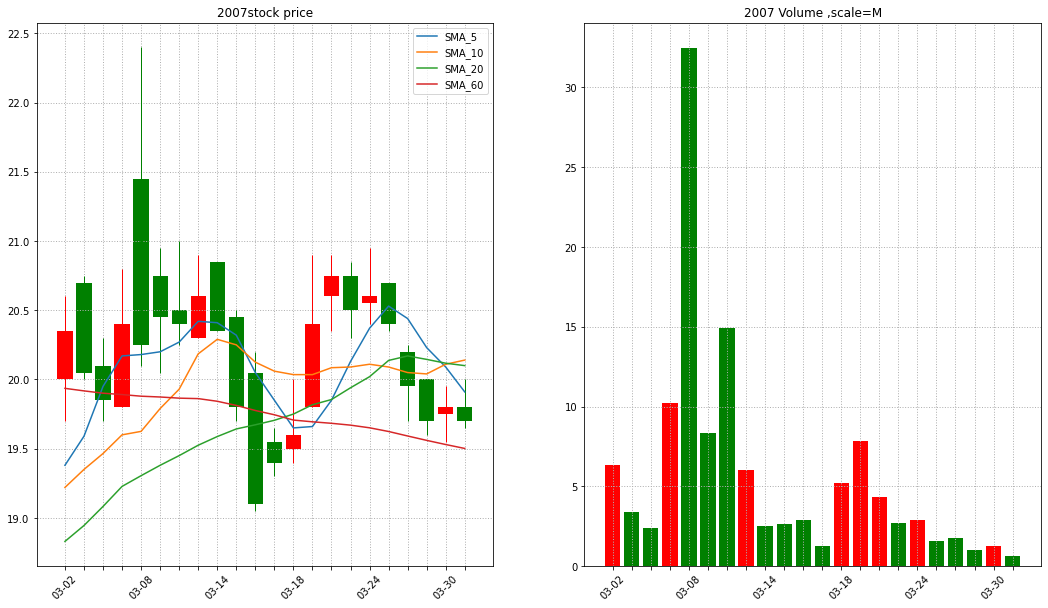

春源


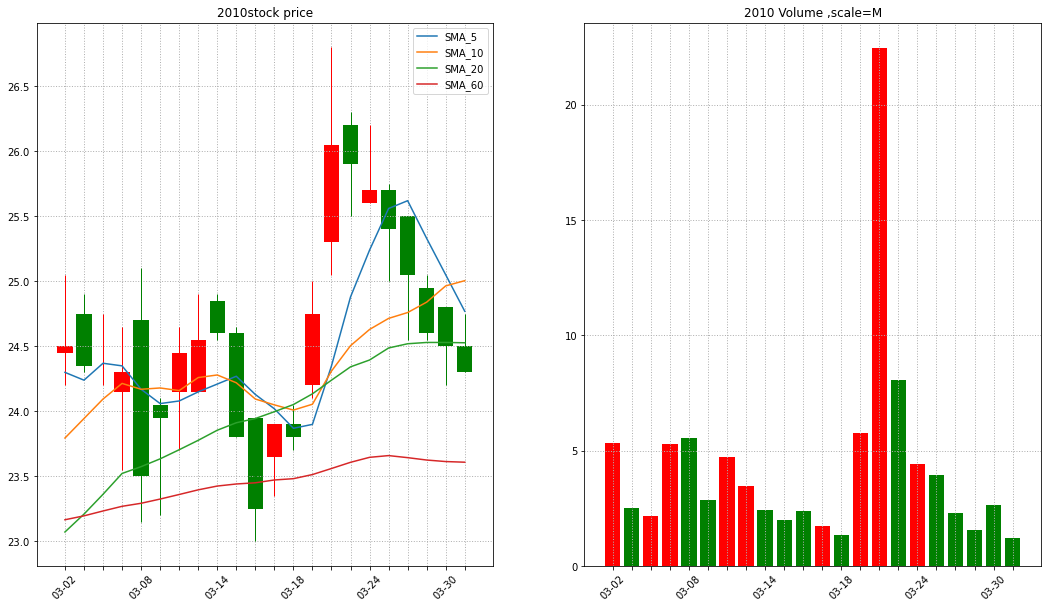

聚亨


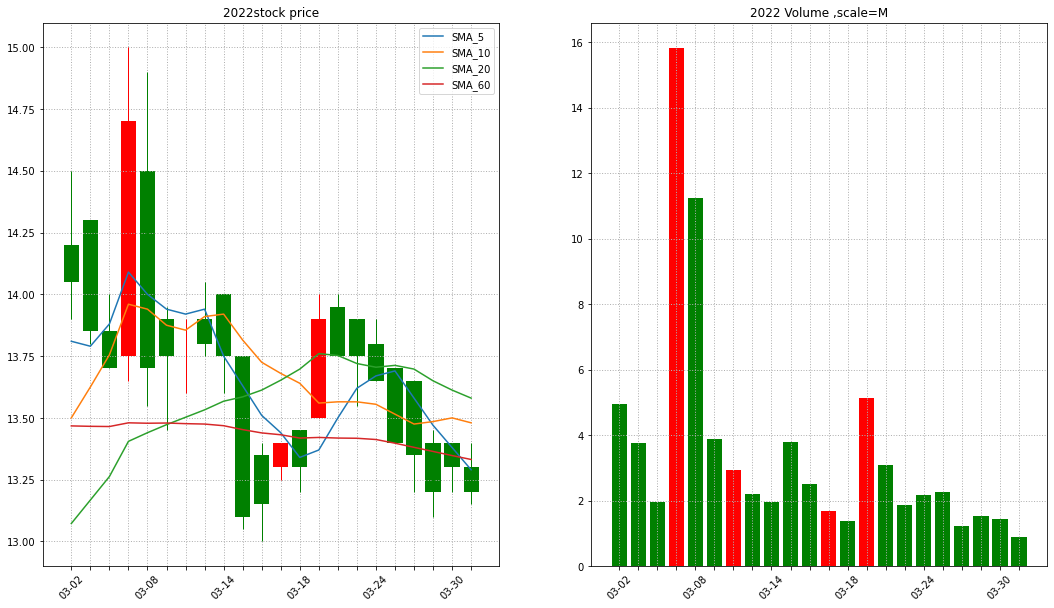

海光


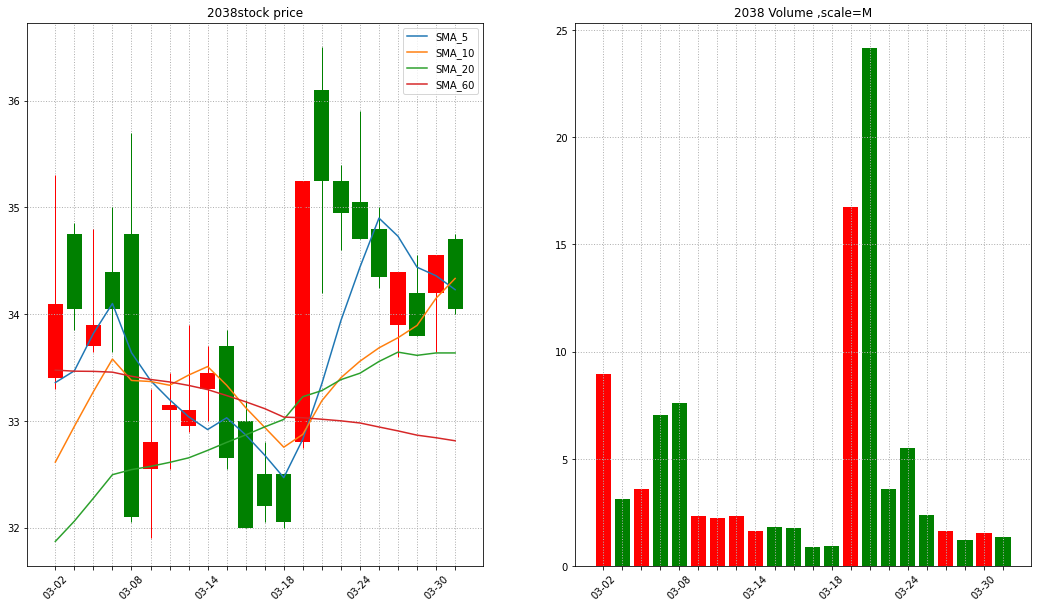

鴻碩


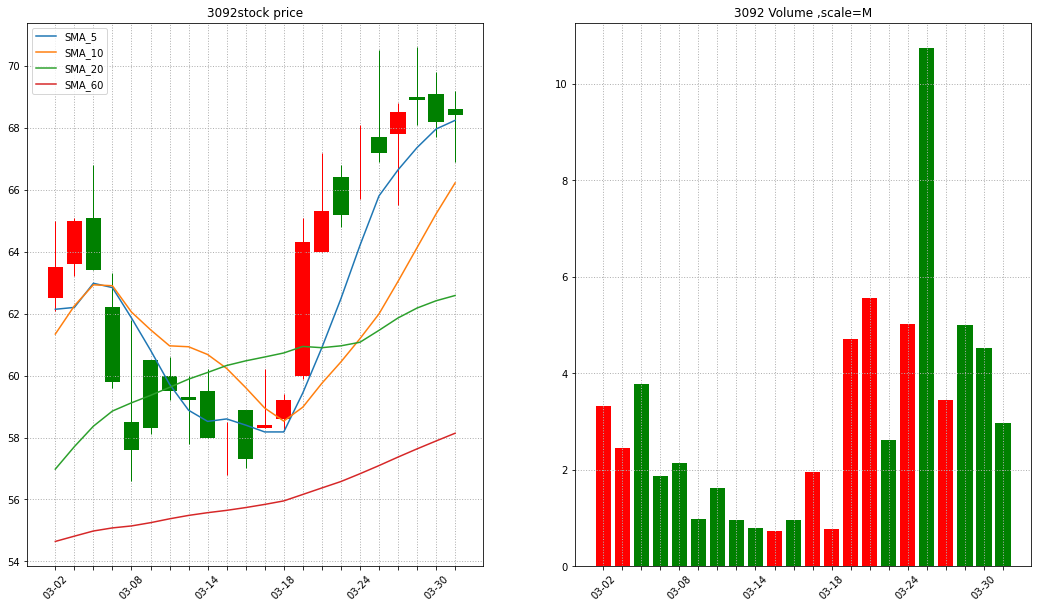

哲固


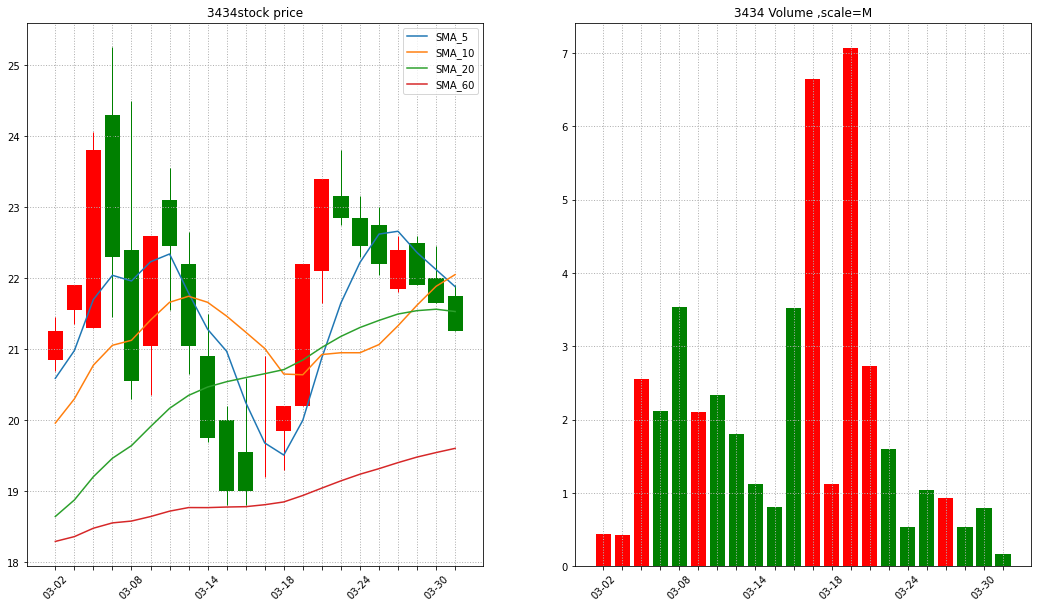

金益鼎


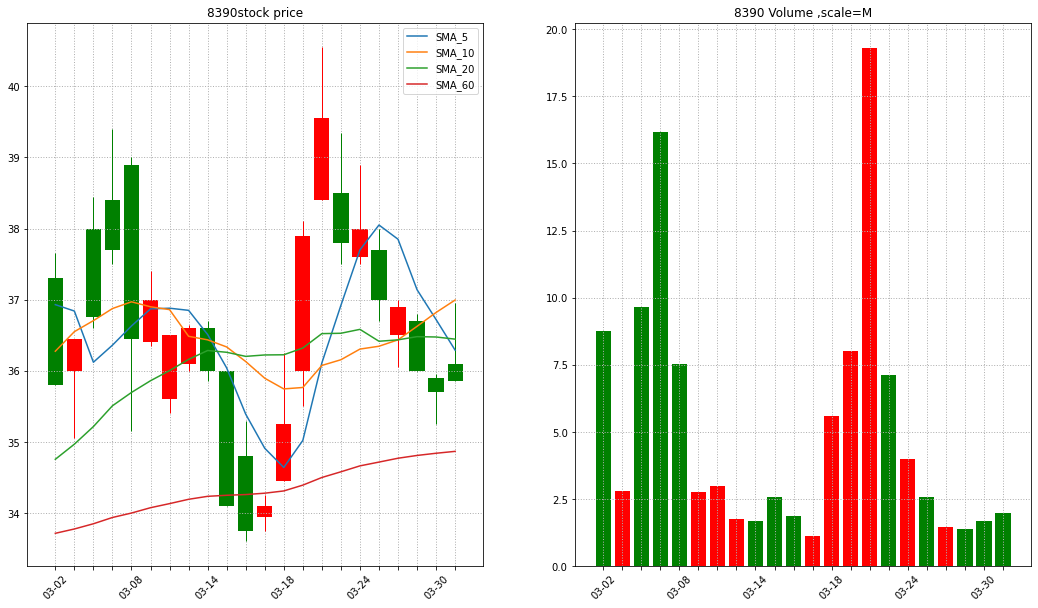

In [4]:
date_plot=date_today-datetime.timedelta(days=30)
for s in 選股模式一_stocks_list[-8]['stocks']: 
     plot.price_and_volume_plot(s,date_plot,date_today,SMA_days=[5,10,20,60])

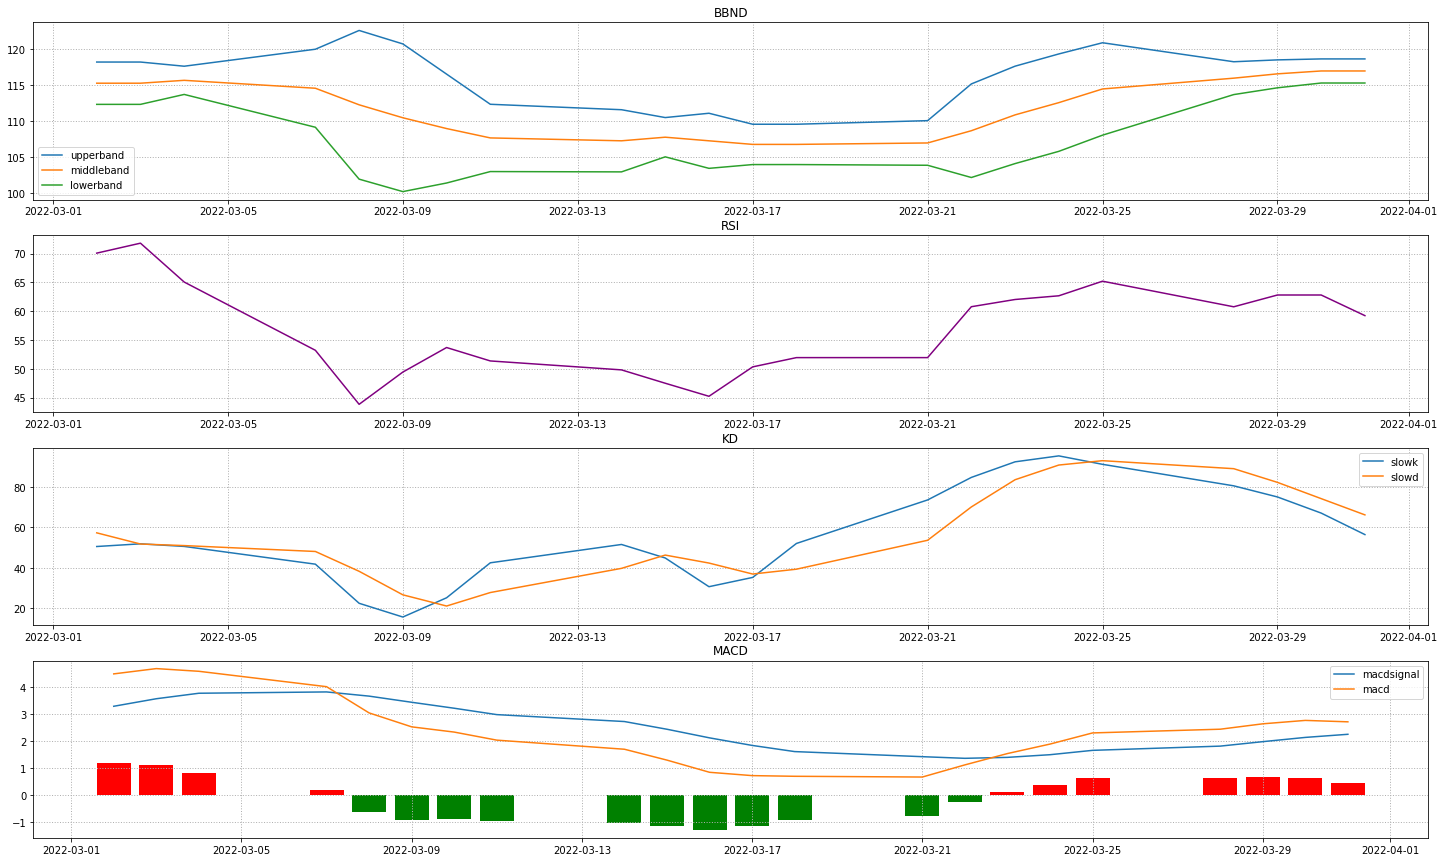

In [5]:
#技術線圖
plot.Technical_index_plot('2915',date_plot)

In [6]:
#選股模式一 testing................
test_stocks=選股模式一(close,open_,high,volume,SMA_20,SMA_5_volume,三大法人買賣超,x=-8)
def 買入(open_df,close_df,st):
    stocks=st['stocks']
    date=st['date'].date()
    stock_list=[]
    
    if date.weekday()==4:
        date_買入=(date+datetime.timedelta(days=3)).strftime("%Y-%m-%d")
    else:
        date_買入=(date+datetime.timedelta(days=1)).strftime("%Y-%m-%d")
    if date_today.hour>=14:
        date_今日=date_today.strftime("%Y-%m-%d")
        if date_today.weekday()==5:
            date_今日=(date_today-datetime.timedelta(days=1)).strftime("%Y-%m-%d")
        if date_today.weekday()==6:
            date_今日=(date_today-datetime.timedelta(days=2)).strftime("%Y-%m-%d")
    else:
        date_今日=(date_today-datetime.timedelta(days=1)).strftime("%Y-%m-%d")
    for stock in stocks:
        stockdic={}
        stockdic['stock id']=stock
        stockdic[f'買入開盤價 {date_買入}']=open_df[stock][date_買入]
        stockdic[f'收盤價 {date_今日}']=close_df[stock][date_今日]
        stockdic['差價']=close_df[stock][date_今日]-open_df[stock][date_買入]
        stockdic['漲幅/跌幅']=str(round((close_df[stock][date_今日]-open_df[stock][date_買入])/open_df[stock][date_買入]*100,2))+"%"
        stock_list.append(stockdic)
    return pd.DataFrame(stock_list)    
s=買入(open_,close,test_stocks)
s

2022-03-21 00:00:00符合選股模式一的股票有7檔股票,包括:['2007' '2010' '2022' '2038' '3092' '3434' '8390']


KeyError: '2022-03-31'

In [ ]:
#其他選股策略............................................................
dmi策略_stocks=dmi策略(close,low,OBV,obv_ema,EMA_144,MINUS_DI,PLUS_DI,ADX,x=-2)
雙重金死叉策略_stocks=雙重金死叉策略(close,dfk,dfd,macd,macdsignal,x=-2)
bbi策略_stocks=bbi策略(close, bbi短均線,bbi長均線,high, low, SMA_5_volume, SMA_20,x=-2)
